**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2023</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: June 08, 2023 23:59 (GMT+3)</center></h4>

## **MNIST RGB Inpainting**

### **Homework Description**

In this assignment, you are asked to design and train two different neural network models for image the inpainting task. In short, inpainting is a process of filling in the missing parts of an image. You will be applying this task on the MNIST RGB dataset, which is created for this homework by processing a subset of the original [MNIST](http://yann.lecun.com/exdb/mnist/) images. It contains RGB digit images from 0 to 1 colored in black, red, blue, or green. You can see a subset of the dataset below. The download link of the dataset is provided in the following parts.

![MNIST RGB Samples](https://drive.google.com/uc?export=view&id=1uy0VENXeb6If-i3uxgDVtnk4qDj7eq_3)

**Using PyTorch is mandatory** for this assignment. You are requested to **submit only a single *.ipynb file** in your submissions (no report needed). If you want to provide further explanations about your work, you can add Markdown cells for this purpose. From [this link](https://www.markdownguide.org/), you can get familiar with the Markdown syntax if you need. Upload your homework with the following filename convention: **\<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb**

Note that this assignment needs a CUDA-enabled GPU to be able to train the models in a reasonable time. If you do not have one, it is suggested to use the [Colab](https://colab.research.google.com/) environment.

**Contact:** [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'. 

**Do not change the cell**.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: Tesla T4
Total GPU Memory: 14.7 GB


### **Setting Library Seeds for Reproducibility**

To make a fair evaluation, the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. 

**Do not change the cell**

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(464)

### **Preparing the Dataset**

The MNIST RGB dataset is downloadable from [this link](https://drive.google.com/file/d/1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ/view?usp=share_link). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [5]:
import gdown # Library to download files from Google Drive
!gdown 1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ # Google Drive ID of the zip file to be downloaded
!unzip -oq mnist_dataset_rgb # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

Downloading...
From: https://drive.google.com/uc?id=1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ
To: /content/mnist_dataset_rgb.zip
100% 63.4M/63.4M [00:00<00:00, 152MB/s]


### **Implementing a Custom Dataset [20 Points]**

In this part, you are requested to implement a custom PyTorch dataset class that reads MNIST RGB images from a dataset split folder. There are two split folders called training and test in the dataset. The model class should take the root directory of a split in the \_\_init\_\_ function and read the images accordingly. Before returning the requested images, you should apply the following steps:

* Apply bicubic interpolation using PIL to resize the images from (28,28) to (32,32) resolution.
* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [6]:
class MnistDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir=root_dir
        non_sort_cls= os.listdir(root_dir)
        non_sort_cls.sort()
        self.classes=non_sort_cls
        data=[]
        cls=[]
        for i in self.classes:
          cls_i=os.listdir(self.root_dir + "/" + i)
          data=[*data,*cls_i]
          cls_list= [i]*len(cls_i)
          cls=[*cls, *cls_list]

        self.length=len(data)
        self.data=data
        self.cls=cls

    def __len__(self):

        return self.length

    def __getitem__(self, data_id):
        cls_name=self.cls[data_id]
        img_name=self.data[data_id]

        img_dir=self.root_dir + "/" + cls_name + "/" + img_name
        img=Image.open(img_dir).resize((32,32), Image.BICUBIC)
        tensor_img= transforms.Compose([transforms.ToTensor()])(img)
        img_scaled=tensor_img*2-1

        return img_scaled 

Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [7]:
train_dataset = MnistDataset("/content/mnist_dataset_rgb/training")
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = MnistDataset("/content/mnist_dataset_rgb/test")
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

**Do not change** the below code. If your implementation is correct, you should be seeing a grid of MNIST RGB images properly.

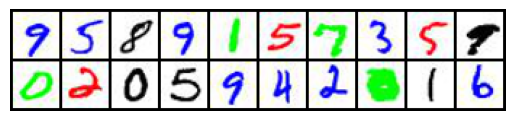

In [8]:
## Uncomment the cell when the dataloader is ready

images = next(iter(train_dataloader))
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Autoencoder Networks [30 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two subnetworks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part of the homework, you are requested to implement two different autoencoder networks, which are fully connected and convolutional autoencoders.

#### **Fully Connected Autoencoder [15 Points]**

Fully connected networks consist of multiple [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). The figure of the architecture is provided below, where the number of nodes is kept small for simplification. 

![Fully Connected Autoencoder Architecture](https://drive.google.com/uc?export=view&id=1JeDQtjvWVoT5dZhVxesQp_XiqAnUvi1i)

In this part, you are requested to implement the layers and the forward function of the model. You should flatten the input image before feeding it to the network and unflatten it when the final activations are obtained. The (input_size, output_size) pairs of the layers should be defined as follows:

**Encoder:**
- (3\*32\*32, 256)
- (256, 64)
- (64, 16)

**Decoder:**
- (16, 64)
- (64, 256)
- (256, 3\*32\*32)

In each layer, [1D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In [9]:
class MnistAutoencoderFC(nn.Module):
    def __init__(self):
        super().__init__()

        self.encode=nn.Sequential(
            nn.Linear(3*32*32, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.02),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.02),

            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(negative_slope=0.02))
        

        self.decode=nn.Sequential(
            nn.Linear(16, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.02),

            nn.Linear(64, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.02),

            nn.Linear(256, 3*32*32),
            nn.Tanh())
       

    def forward(self, x):
      x=x.reshape(-1,32*32*3)
      enc = self.encode(x)
      dec = self.decode(enc)
      dec=dec.reshape(-1,3,32,32)
      return dec

#### **Convolutional Autoencoder [15 Points]**

In this part, you are requested to implement an autoencoder model using convolutional layers. The architecture of a convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=18Ztf-zhMFC_IXDTnvGCUeGgZx-7duu0o)

 The (in_channel, out_channel) pairs of the layers should be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers. 

In the encoder part of the network, use max pooling in each layer for decreasing the resolution. The stride size should be set to one in these layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back. 

In [10]:
import torch.nn as nn

class MnistAutoencoderConv(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.encode = nn.Sequential(
            
            nn.Conv2d(3, 16, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        
        self.decode = nn.Sequential(
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        enc = self.encode(x)
        dec = self.decode(enc)
        return dec

### **Implementing the Training Loop [15 Points]**

Define your training loop in this function. In the following parts, this function will be called to train both the fully connected and the convolutional autoencoders. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch. You should sum the iteration losses up during an epoch and take the mean of them to calculate the running loss of that epoch.

To be able to learn inpainting, you should mask the input images as follows:

![MNIST Masking](https://drive.google.com/uc?export=view&id=1gIELbRSE188PQHv_uGktPX_2cvAtMbN-)

Simply, you should set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, you should use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [11]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):

    model.train()

    losses=[]

    for epoch in range(num_epochs):

        print(f'Epoch {epoch+1}/{num_epochs}')
        losses_per_epoch=[]

        for data in tqdm(train_dataloader):

          data=data.to(device)
          mask=data.clone()
          mask[:,:,:,16:]=-1
          
          out=model(mask)
          loss=loss_func(out,data)
          losses_per_epoch.append(loss)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        epoch_loss=sum(losses_per_epoch)/len(losses_per_epoch)
        losses.append(epoch_loss.item())
        print("Loss:",epoch_loss.item())

    return losses

### **Implementing the Evaluation Function [15 Points]**

Implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [12]:
def evaluate_model(model, test_dataloader,loss_func):
  model.eval()
  with torch.no_grad():

    losses=[]

    for test_data in tqdm(test_dataloader):

      test_data=test_data.to(device)
      mask_data=test_data.clone()
      mask_data[:,:,:,16:]=-1

      out=model(mask_data)
      loss=loss_func(test_data,out).item()
      losses.append(loss)

    total_loss=sum(losses)/len(losses)

  return total_loss

### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later. 

**Do not change the cell**

In [13]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      inpainted_images = model(masked_images.cuda()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the FC Model [5 Points]**

Define your loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, call evaluate_model function that you implemented and print the accuracy the model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.



In [14]:
seed_everything(464)
model_fc = MnistAutoencoderFC() ## Uncomment when the model is implemented
loss_fc=torch.nn.MSELoss()
opt_fc=torch.optim.Adam(model_fc.parameters(), lr=2e-4)
model_fc = model_fc.to(device)
train_losses_fc=train_model(model_fc, train_dataloader, opt_fc, loss_fc, 50)

Epoch 1/50


100%|██████████| 782/782 [00:29<00:00, 26.45it/s]


Loss: 0.15080676972866058
Epoch 2/50


100%|██████████| 782/782 [00:23<00:00, 32.60it/s]


Loss: 0.08764787763357162
Epoch 3/50


100%|██████████| 782/782 [00:25<00:00, 31.05it/s]


Loss: 0.07854127883911133
Epoch 4/50


100%|██████████| 782/782 [00:26<00:00, 29.40it/s]


Loss: 0.07357978075742722
Epoch 5/50


100%|██████████| 782/782 [00:25<00:00, 30.55it/s]


Loss: 0.07032547146081924
Epoch 6/50


100%|██████████| 782/782 [00:25<00:00, 30.37it/s]


Loss: 0.06780710071325302
Epoch 7/50


100%|██████████| 782/782 [00:26<00:00, 29.70it/s]


Loss: 0.06569090485572815
Epoch 8/50


100%|██████████| 782/782 [00:25<00:00, 30.14it/s]


Loss: 0.06433216482400894
Epoch 9/50


100%|██████████| 782/782 [00:26<00:00, 29.57it/s]


Loss: 0.06278397142887115
Epoch 10/50


100%|██████████| 782/782 [00:26<00:00, 29.35it/s]


Loss: 0.06148791313171387
Epoch 11/50


100%|██████████| 782/782 [00:28<00:00, 27.45it/s]


Loss: 0.060519468039274216
Epoch 12/50


100%|██████████| 782/782 [00:27<00:00, 28.82it/s]


Loss: 0.05954807251691818
Epoch 13/50


100%|██████████| 782/782 [00:26<00:00, 29.59it/s]


Loss: 0.0589432418346405
Epoch 14/50


100%|██████████| 782/782 [00:26<00:00, 29.55it/s]


Loss: 0.058231279253959656
Epoch 15/50


100%|██████████| 782/782 [00:26<00:00, 29.92it/s]


Loss: 0.057429879903793335
Epoch 16/50


100%|██████████| 782/782 [00:26<00:00, 30.02it/s]


Loss: 0.056935325264930725
Epoch 17/50


100%|██████████| 782/782 [00:25<00:00, 30.23it/s]


Loss: 0.05629807338118553
Epoch 18/50


100%|██████████| 782/782 [00:25<00:00, 30.44it/s]


Loss: 0.05565522611141205
Epoch 19/50


100%|██████████| 782/782 [00:26<00:00, 29.28it/s]


Loss: 0.055187780410051346
Epoch 20/50


100%|██████████| 782/782 [00:27<00:00, 28.64it/s]


Loss: 0.05475462228059769
Epoch 21/50


100%|██████████| 782/782 [00:26<00:00, 29.03it/s]


Loss: 0.05424825847148895
Epoch 22/50


100%|██████████| 782/782 [00:27<00:00, 28.28it/s]


Loss: 0.05398018658161163
Epoch 23/50


100%|██████████| 782/782 [00:26<00:00, 29.20it/s]


Loss: 0.053449779748916626
Epoch 24/50


100%|██████████| 782/782 [00:26<00:00, 29.31it/s]


Loss: 0.0532057024538517
Epoch 25/50


100%|██████████| 782/782 [00:26<00:00, 29.23it/s]


Loss: 0.05269027128815651
Epoch 26/50


100%|██████████| 782/782 [00:26<00:00, 29.43it/s]


Loss: 0.05242246389389038
Epoch 27/50


100%|██████████| 782/782 [00:27<00:00, 27.94it/s]


Loss: 0.0521790087223053
Epoch 28/50


100%|██████████| 782/782 [00:27<00:00, 28.39it/s]


Loss: 0.05186459422111511
Epoch 29/50


100%|██████████| 782/782 [00:26<00:00, 29.24it/s]


Loss: 0.05155413970351219
Epoch 30/50


100%|██████████| 782/782 [00:27<00:00, 28.73it/s]


Loss: 0.051271628588438034
Epoch 31/50


100%|██████████| 782/782 [00:35<00:00, 22.03it/s]


Loss: 0.050948407500982285
Epoch 32/50


100%|██████████| 782/782 [00:27<00:00, 28.36it/s]


Loss: 0.050804492086172104
Epoch 33/50


100%|██████████| 782/782 [00:27<00:00, 28.72it/s]


Loss: 0.05054659768939018
Epoch 34/50


100%|██████████| 782/782 [00:28<00:00, 27.05it/s]


Loss: 0.05028775706887245
Epoch 35/50


100%|██████████| 782/782 [00:27<00:00, 28.17it/s]


Loss: 0.050124458968639374
Epoch 36/50


100%|██████████| 782/782 [00:27<00:00, 28.81it/s]


Loss: 0.0498279370367527
Epoch 37/50


100%|██████████| 782/782 [00:26<00:00, 29.62it/s]


Loss: 0.04979408532381058
Epoch 38/50


100%|██████████| 782/782 [00:26<00:00, 29.38it/s]


Loss: 0.04949125647544861
Epoch 39/50


100%|██████████| 782/782 [00:26<00:00, 29.48it/s]


Loss: 0.0493052639067173
Epoch 40/50


100%|██████████| 782/782 [00:26<00:00, 29.09it/s]


Loss: 0.049132026731967926
Epoch 41/50


100%|██████████| 782/782 [00:26<00:00, 29.34it/s]


Loss: 0.048883356153964996
Epoch 42/50


100%|██████████| 782/782 [00:28<00:00, 27.11it/s]


Loss: 0.04883189871907234
Epoch 43/50


100%|██████████| 782/782 [00:26<00:00, 29.15it/s]


Loss: 0.04855194315314293
Epoch 44/50


100%|██████████| 782/782 [00:26<00:00, 29.12it/s]


Loss: 0.048504993319511414
Epoch 45/50


100%|██████████| 782/782 [00:26<00:00, 29.22it/s]


Loss: 0.048280779272317886
Epoch 46/50


100%|██████████| 782/782 [00:26<00:00, 29.21it/s]


Loss: 0.04817786440253258
Epoch 47/50


100%|██████████| 782/782 [00:27<00:00, 28.92it/s]


Loss: 0.0479109063744545
Epoch 48/50


100%|██████████| 782/782 [00:27<00:00, 28.85it/s]


Loss: 0.04800892248749733
Epoch 49/50


100%|██████████| 782/782 [00:27<00:00, 28.85it/s]


Loss: 0.047784872353076935
Epoch 50/50


100%|██████████| 782/782 [00:26<00:00, 28.99it/s]

Loss: 0.047591157257556915


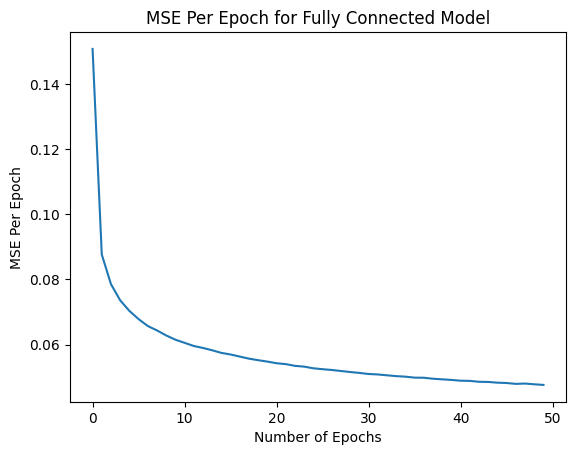

In [22]:
plt.figure()
plt.plot(train_losses_fc)
plt.xlabel("Number of Epochs")
plt.ylabel("MSE Per Epoch")
plt.title("MSE Per Epoch for Fully Connected Model")
plt.show()

In [15]:
test_loss_fc=evaluate_model(model_fc, test_dataloader,loss_fc)  
print("\n")
print("Test Loss: ",test_loss_fc)

100%|██████████| 20/20 [00:04<00:00,  4.09it/s]



Test Loss:  0.047600108105689286


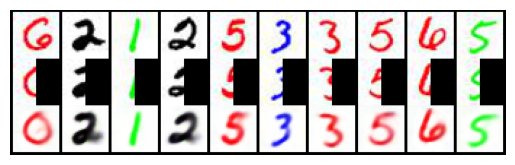

In [17]:
visualize_inpainting(model_fc, test_dataset) ## Uncomment when the model is trained

### **Training and Evaluating the Convolutional Model [5 Points]**

Apply the same steps given in the FC Autoencoder part.

In [18]:
seed_everything(464)
model_conv = MnistAutoencoderConv() ## Uncomment when the model is implemented
loss_conv=torch.nn.MSELoss()
opt_conv=torch.optim.Adam(model_conv.parameters(), lr=2e-4)
model_conv = model_conv.to(device)
train_losses_conv=train_model(model_conv, train_dataloader, opt_conv, loss_conv, 50)

Epoch 1/50


100%|██████████| 782/782 [00:30<00:00, 25.83it/s]


Loss: 0.3054704964160919
Epoch 2/50


100%|██████████| 782/782 [00:25<00:00, 30.58it/s]


Loss: 0.09086249023675919
Epoch 3/50


100%|██████████| 782/782 [00:26<00:00, 29.77it/s]


Loss: 0.07384936511516571
Epoch 4/50


100%|██████████| 782/782 [00:26<00:00, 29.61it/s]


Loss: 0.06812484562397003
Epoch 5/50


100%|██████████| 782/782 [00:26<00:00, 29.59it/s]


Loss: 0.06499343365430832
Epoch 6/50


100%|██████████| 782/782 [00:27<00:00, 28.41it/s]


Loss: 0.06291928142309189
Epoch 7/50


100%|██████████| 782/782 [00:29<00:00, 26.12it/s]


Loss: 0.06132920831441879
Epoch 8/50


100%|██████████| 782/782 [00:26<00:00, 29.47it/s]


Loss: 0.06017094478011131
Epoch 9/50


100%|██████████| 782/782 [00:26<00:00, 29.18it/s]


Loss: 0.05912097916007042
Epoch 10/50


100%|██████████| 782/782 [00:26<00:00, 29.16it/s]


Loss: 0.05826893821358681
Epoch 11/50


100%|██████████| 782/782 [00:26<00:00, 29.25it/s]


Loss: 0.05753125250339508
Epoch 12/50


100%|██████████| 782/782 [00:27<00:00, 28.95it/s]


Loss: 0.056832730770111084
Epoch 13/50


100%|██████████| 782/782 [00:26<00:00, 29.38it/s]


Loss: 0.05621885508298874
Epoch 14/50


100%|██████████| 782/782 [00:27<00:00, 28.91it/s]


Loss: 0.055800728499889374
Epoch 15/50


100%|██████████| 782/782 [00:27<00:00, 28.63it/s]


Loss: 0.05523255839943886
Epoch 16/50


100%|██████████| 782/782 [00:27<00:00, 28.92it/s]


Loss: 0.05487519130110741
Epoch 17/50


100%|██████████| 782/782 [00:27<00:00, 28.71it/s]


Loss: 0.05451776459813118
Epoch 18/50


100%|██████████| 782/782 [00:27<00:00, 28.43it/s]


Loss: 0.05418764799833298
Epoch 19/50


100%|██████████| 782/782 [00:26<00:00, 29.09it/s]


Loss: 0.053827714174985886
Epoch 20/50


100%|██████████| 782/782 [00:26<00:00, 29.41it/s]


Loss: 0.053541623055934906
Epoch 21/50


100%|██████████| 782/782 [00:26<00:00, 29.63it/s]


Loss: 0.053282856941223145
Epoch 22/50


100%|██████████| 782/782 [00:26<00:00, 29.27it/s]


Loss: 0.053098127245903015
Epoch 23/50


100%|██████████| 782/782 [00:28<00:00, 27.89it/s]


Loss: 0.052764881402254105
Epoch 24/50


100%|██████████| 782/782 [00:26<00:00, 29.01it/s]


Loss: 0.05258253961801529
Epoch 25/50


100%|██████████| 782/782 [00:26<00:00, 29.07it/s]


Loss: 0.052323661744594574
Epoch 26/50


100%|██████████| 782/782 [00:26<00:00, 29.63it/s]


Loss: 0.052098631858825684
Epoch 27/50


100%|██████████| 782/782 [00:26<00:00, 29.22it/s]


Loss: 0.052007850259542465
Epoch 28/50


100%|██████████| 782/782 [00:26<00:00, 29.37it/s]


Loss: 0.05179395526647568
Epoch 29/50


100%|██████████| 782/782 [00:27<00:00, 28.73it/s]


Loss: 0.05157703533768654
Epoch 30/50


100%|██████████| 782/782 [00:27<00:00, 28.39it/s]


Loss: 0.05145517736673355
Epoch 31/50


100%|██████████| 782/782 [00:27<00:00, 28.59it/s]


Loss: 0.05131751671433449
Epoch 32/50


100%|██████████| 782/782 [00:26<00:00, 29.27it/s]


Loss: 0.05113636329770088
Epoch 33/50


100%|██████████| 782/782 [00:26<00:00, 29.32it/s]


Loss: 0.050976306200027466
Epoch 34/50


100%|██████████| 782/782 [00:27<00:00, 28.58it/s]


Loss: 0.050848785787820816
Epoch 35/50


100%|██████████| 782/782 [00:28<00:00, 27.17it/s]


Loss: 0.05071840435266495
Epoch 36/50


100%|██████████| 782/782 [00:28<00:00, 27.73it/s]


Loss: 0.05064456909894943
Epoch 37/50


100%|██████████| 782/782 [00:28<00:00, 27.82it/s]


Loss: 0.05046289786696434
Epoch 38/50


100%|██████████| 782/782 [00:28<00:00, 27.84it/s]


Loss: 0.05036215856671333
Epoch 39/50


100%|██████████| 782/782 [00:28<00:00, 27.42it/s]


Loss: 0.05032931640744209
Epoch 40/50


100%|██████████| 782/782 [00:28<00:00, 27.75it/s]


Loss: 0.050195030868053436
Epoch 41/50


100%|██████████| 782/782 [00:27<00:00, 28.08it/s]


Loss: 0.05011538416147232
Epoch 42/50


100%|██████████| 782/782 [00:28<00:00, 27.47it/s]


Loss: 0.05000986158847809
Epoch 43/50


100%|██████████| 782/782 [00:28<00:00, 27.72it/s]


Loss: 0.04992257058620453
Epoch 44/50


100%|██████████| 782/782 [00:27<00:00, 27.94it/s]


Loss: 0.0498778410255909
Epoch 45/50


100%|██████████| 782/782 [00:28<00:00, 27.77it/s]


Loss: 0.04971606656908989
Epoch 46/50


100%|██████████| 782/782 [00:27<00:00, 28.64it/s]


Loss: 0.04964996874332428
Epoch 47/50


100%|██████████| 782/782 [00:27<00:00, 28.61it/s]


Loss: 0.04952126368880272
Epoch 48/50


100%|██████████| 782/782 [00:26<00:00, 29.29it/s]


Loss: 0.049489304423332214
Epoch 49/50


100%|██████████| 782/782 [00:26<00:00, 29.50it/s]


Loss: 0.049446724355220795
Epoch 50/50


100%|██████████| 782/782 [00:26<00:00, 29.55it/s]

Loss: 0.049326732754707336


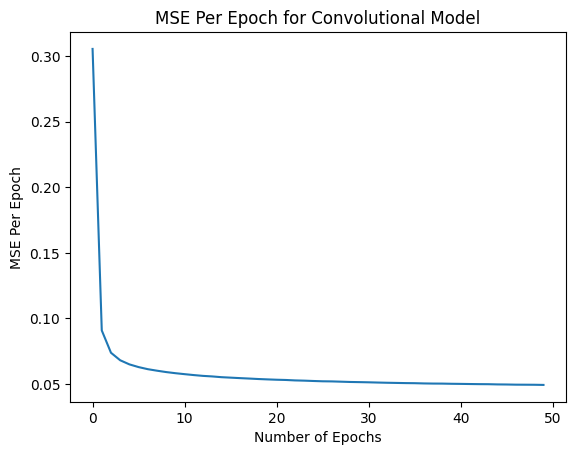

In [19]:
plt.figure()
plt.plot(train_losses_conv)
plt.xlabel("Number of Epochs")
plt.ylabel("MSE Per Epoch")
plt.title("MSE Per Epoch for Convolutional Model")
plt.show()

In [20]:
test_loss_conv=evaluate_model(model_conv, test_dataloader,loss_conv)  
print("\n")
print("Test Loss: ",test_loss_conv)

100%|██████████| 20/20 [00:04<00:00,  4.24it/s]



Test Loss:  0.04958275305107236


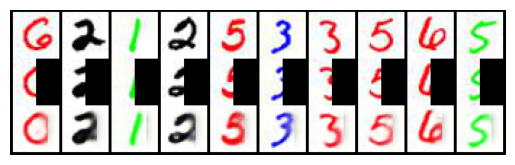

In [21]:
visualize_inpainting(model_conv, test_dataset) ## Uncomment when the model is trained

### **Discussion [10 Points]**

Discuss the results that you obtained after training the models. Compare the inpainting performances by the visualizations and the accuracy metrics. You can write your answer in the below cell.

---


Both of the models succesfully reconsturcted most of the number images succesfully;however, there were some erros. Firstly, as seen from the reconstruction images "6" at the 1st column is reconstructed badly. That is to say even if the original number is "6" both of the models gave it as "0". I think this problem was an expected one because when we mask the right half of the images, the left half of some numbers are similar to each other, for example in this one you can see that when the right side is masked, the number cannot be understood it could be either 0 or 9. Also this problem can be repeated if we masked the left side of the images for 3 and 8 or 9 and 0. Fortunateley, the rest of the numbers are truely reconsturcted and all of them can be easily recognizable. However, there are some differences between model outputs. For example as seen from the inpaintings "5" at the 5th column is seen blurry in convolutional  model while the other one is slightly better. 

If we check the losses of the models in training part it can be seen that the performances of the models are highly similar to each other. While the final loss for the fully connected model is  around 0.0476, the final loss for the convolutinal model is 0.0493. Therefore, fully connected model is slightly better for traning set. Also when we check the evaluation results it can be seen that the loss for convolutional model is 0.0496 and the loss for fully connected model is 0.0476. Those results are close to the final loss of training stages as expected. Just looking those losses we can say that those models perform similarly but it is natural for fully connected model to gave slightly better inpaintings since it gave less loss at the end.

Briefly, the losses got from train and test sets are coherent with the inpaintings results. Even if we couldn't perfectly reconstruct all of the images, fortunately most of them are accurately inpainted.


---